In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from collections import Counter
from sklearn.metrics import accuracy_score

In [13]:
from kagglehub import dataset_download

dataset_path = dataset_download('ashishsaxena2209/animal-image-datasetdog-cat-and-panda')
data_dir = os.path.join(dataset_path, 'animals')

IMAGE_SIZE = (32, 32)
NUM_CLASSES = 3
CLASS_NAMES = ["cats", "dogs", "panda"]
SAMPLES_PER_CLASS = 100
FOLDS = 5

In [14]:
def load_images_from_folders(base_path, target_size=(32, 32)):
    data, labels = [], []
    for label_idx, class_name in enumerate(CLASS_NAMES):
        folder = os.path.join(base_path, class_name)
        images = os.listdir(folder)[:SAMPLES_PER_CLASS]
        for img_name in images:
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                resized = cv2.resize(gray, target_size)
                data.append(resized.flatten())
                labels.append(label_idx)
    return np.array(data), np.array(labels)

data, targets = load_images_from_folders(data_dir, IMAGE_SIZE)
print(f"Loaded {len(data)} images.")

Loaded 300 images.


In [15]:
def compute_distance(x1, x2, metric='l2'):
    if metric == 'l1':
        return np.sum(np.abs(x1 - x2))
    else:
        return np.sqrt(np.sum((x1 - x2)**2))

def knn_predict(x_train, y_train, x_test, k=3, metric='l2'):
    predictions = []
    for test_sample in x_test:
        distances = [compute_distance(test_sample, train_sample, metric) for train_sample in x_train]
        k_indices = np.argsort(distances)[:k]
        k_labels = y_train[k_indices]
        most_common = Counter(k_labels).most_common(1)
        predictions.append(most_common[0][0])
    return np.array(predictions)

In [16]:
def evaluate_knn(data, targets, k_values, metric='l2'):
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    avg_accuracies = []

    for k in k_values:
        fold_accuracies = []
        for train_idx, val_idx in kf.split(data):
            x_train, x_val = data[train_idx], data[val_idx]
            y_train, y_val = targets[train_idx], targets[val_idx]

            preds = knn_predict(x_train, y_train, x_val, k=k, metric=metric)
            acc = accuracy_score(y_val, preds)
            fold_accuracies.append(acc)
        avg_accuracy = np.mean(fold_accuracies)
        avg_accuracies.append(avg_accuracy)
        print(f"K={k} ({metric}): Accuracy={avg_accuracy:.4f}")

    return avg_accuracies

K=1 (l1): Accuracy=0.3667
K=2 (l1): Accuracy=0.3667
K=3 (l1): Accuracy=0.3867
K=4 (l1): Accuracy=0.4067
K=5 (l1): Accuracy=0.4000
K=6 (l1): Accuracy=0.3933
K=7 (l1): Accuracy=0.3800
K=8 (l1): Accuracy=0.3767
K=9 (l1): Accuracy=0.4067
K=10 (l1): Accuracy=0.4000
K=1 (l2): Accuracy=0.4633
K=2 (l2): Accuracy=0.4633
K=3 (l2): Accuracy=0.4167
K=4 (l2): Accuracy=0.4567
K=5 (l2): Accuracy=0.4500
K=6 (l2): Accuracy=0.4733
K=7 (l2): Accuracy=0.4667
K=8 (l2): Accuracy=0.4567
K=9 (l2): Accuracy=0.4600
K=10 (l2): Accuracy=0.4633


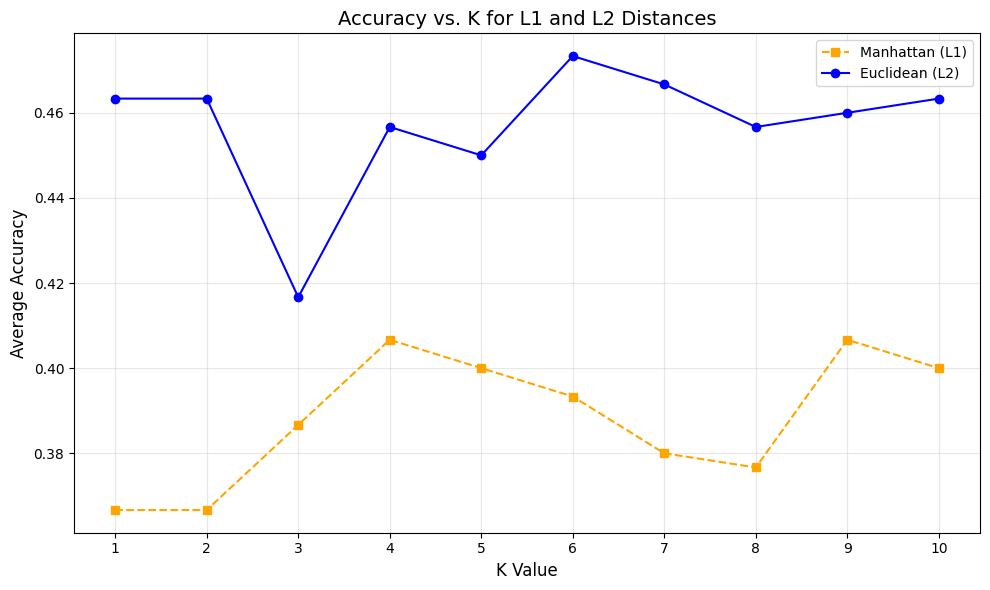

In [17]:
k_values = list(range(1, 11))
acc_l1 = evaluate_knn(data, targets, k_values, metric='l1')
acc_l2 = evaluate_knn(data, targets, k_values, metric='l2')

plt.figure(figsize=(10, 6))
plt.plot(k_values, acc_l1, marker='s', label='Manhattan (L1)', color='orange', linestyle='--')
plt.plot(k_values, acc_l2, marker='o', label='Euclidean (L2)', color='blue')
plt.title("Accuracy vs. K for L1 and L2 Distances", fontsize=14)
plt.xlabel("K Value", fontsize=12)
plt.ylabel("Average Accuracy", fontsize=12)
plt.xticks(k_values)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

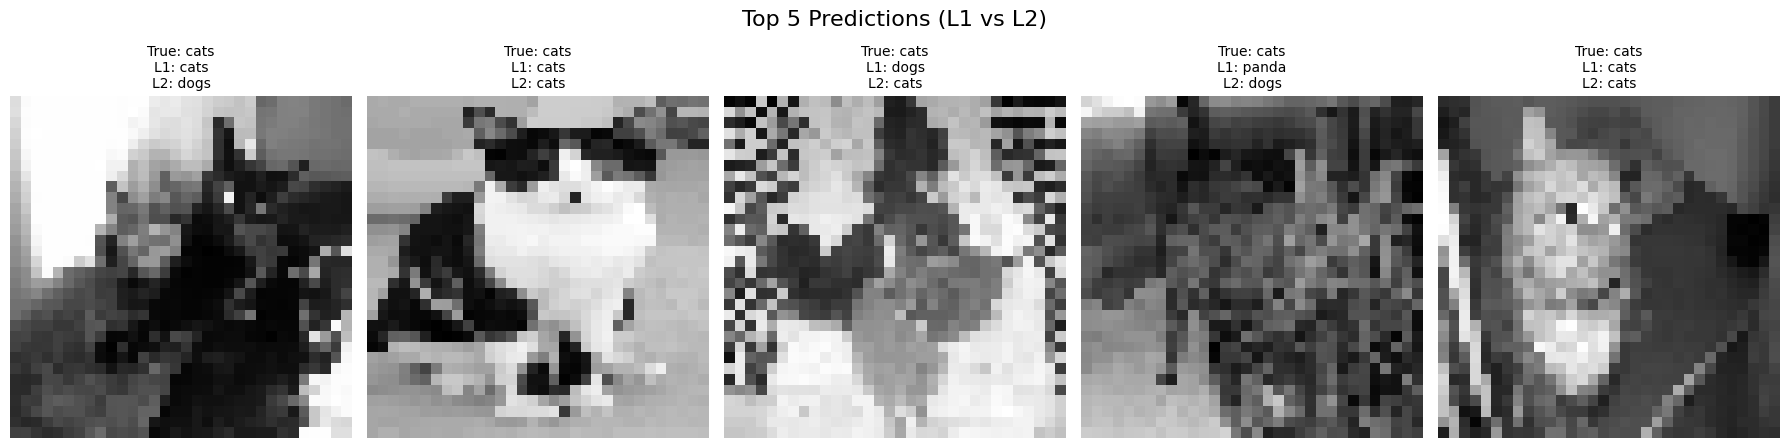

In [18]:
def display_top_predictions(data, targets, k=3):
    preds_l1 = knn_predict(data, targets, data[:5], k=k, metric='l1')
    preds_l2 = knn_predict(data, targets, data[:5], k=k, metric='l2')

    plt.figure(figsize=(18, 5))
    for i in range(5):
        img = data[i].reshape(IMAGE_SIZE)
        true_label = CLASS_NAMES[targets[i]]
        pred_label_l1 = CLASS_NAMES[preds_l1[i]]
        pred_label_l2 = CLASS_NAMES[preds_l2[i]]

        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label}\nL1: {pred_label_l1}\nL2: {pred_label_l2}", fontsize=10)
        plt.axis("off")

    plt.suptitle("Top 5 Predictions (L1 vs L2)", fontsize=16)
    plt.tight_layout()
    plt.show()

display_top_predictions(data, targets, k=3)


##Discussion:

The plot illustrates the performance of the K-Nearest Neighbors (KNN) classifier using Manhattan (L1) and Euclidean (L2) distance metrics across various values of K.

From the graph, it's clear that Euclidean (L2) distance consistently outperforms Manhattan (L1) in terms of classification accuracy across all K values. The average accuracy for L2 remains above 0.45, whereas L1 accuracy fluctuates between 0.37 and 0.41. This suggests that L2 distance is more effective at capturing relevant differences between image feature vectors in this dataset.

The best performance for L2 occurs at K=6, peaking near 47.3%, while the highest L1 accuracy is around 40.7% at K=4 and K=9. This performance gap may be attributed to the fact that Euclidean distance better reflects geometric similarity in high-dimensional image data.

In conclusion, for grayscale image classification tasks using flattened vectors like in this dataset, Euclidean distance proves to be the more reliable metric for KNN.
